# TP01 - Inteligência Artificial: Clusterização

**Aluno:** Gabriel Tauber
**Data:** 14/08/2025

## Objetivos do Trabalho

Este trabalho aborda conceitos fundamentais de clusterização, com foco no algoritmo K-means. Utilizaremos dois datasets:
1. **ShopMania** - Dataset de classificação de produtos do Kaggle
2. **make_blobs** - Dataset sintético do scikit-learn

As questões abordam desde conceitos teóricos até aplicações práticas, incluindo análise de limitações e técnicas de redução de dimensionalidade.

## Configuração Inicial

Importação das bibliotecas necessárias para o trabalho.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D
import kagglehub
import warnings
import os

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


## Questão 1: Conceitos de Clusterização

### O que é Clusterização?

A clusterização é uma técnica de **aprendizado não supervisionado** que visa agrupar objetos similares em grupos (clusters), de forma que:
- Objetos no mesmo cluster sejam mais similares entre si
- Objetos em clusters diferentes sejam mais dissimilares

### Objetivos da Clusterização

1. **Descoberta de Estruturas**: Identificar padrões naturais nos dados sem conhecimento prévio
2. **Segmentação**: Dividir dados em grupos significativos para análise específica
3. **Redução de Complexidade**: Representar grandes conjuntos de dados por seus grupos representativos
4. **Detecção de Anomalias**: Identificar pontos que não se encaixam em nenhum cluster
5. **Pré-processamento**: Preparar dados para outros algoritmos de ML

### Vantagens

1. **Não Requer Labels**: Funciona com dados não rotulados, abundantes no mundo real
2. **Exploração de Dados**: Revela insights não óbvios sobre a estrutura dos dados
3. **Versatilidade**: Aplicável em diversos domínios (marketing, biologia, processamento de imagens)
4. **Escalabilidade**: Muitos algoritmos funcionam bem com grandes volumes de dados
5. **Interpretabilidade**: Clusters podem ter significado semântico claro

### Maiores Dificuldades

1. **Escolha do Número de Clusters (k)**: Não há método universal para determinar k ótimo
2. **Validação de Resultados**: Sem labels verdadeiros, é difícil avaliar a qualidade objetivamente
3. **Sensibilidade a Outliers**: Pontos anômalos podem distorcer significativamente os clusters
4. **Maldição da Dimensionalidade**: Performance degrada com muitas features
5. **Dependência de Inicialização**: Resultados podem variar com diferentes pontos iniciais
6. **Assumções sobre Forma dos Clusters**: Muitos algoritmos assumem formas específicas (ex: K-means assume clusters esféricos)
7. **Escala e Normalização**: Features em escalas diferentes podem dominar a distância

## Questão 2: K-means no Dataset ShopMania

Aplicação do algoritmo K-means no dataset de comparação de produtos da ShopMania.

### 2.1 Download e Carregamento do Dataset

In [17]:
print("Baixando dataset ShopMania...")
path = kagglehub.dataset_download("lakritidis/product-classification-and-categorization")
print(f"Dataset baixado em: {path}")

for root, dirs, files in os.walk(path):
    for file in files:
        print(f"  - {file}")

Baixando dataset ShopMania...
Dataset baixado em: /Users/gtauber/.cache/kagglehub/datasets/lakritidis/product-classification-and-categorization/versions/1
  - shopmania.xml
  - pricerunner_aggregate.csv
  - skroutz_aggregate.csv
  - pricerunner_aggregate.xml
  - skroutz_aggregate.xml
  - shopmania.csv


In [18]:
file_path = os.path.join(path, 'shopmania.csv')
df = pd.read_csv(file_path)

print(f"Shape do dataset: {df.shape}")
print(f"\nColunas: {df.columns.tolist()}")
print(f"\nPrimeiras linhas:")
df.head()

Shape do dataset: (313705, 4)

Colunas: ['1', 'boston red sox for men by boston red sox eau de toilette spray 3.4 oz', '2', 'Collectibles']

Primeiras linhas:


,1,boston red sox for men by boston red sox eau de toilette spray 3.4 oz,2,Collectibles
0,2,twilight central park print,2,Collectibles
1,3,fox print,2,Collectibles
2,4,circulo de papel wall art,2,Collectibles
3,5,hidden path print,2,Collectibles
4,6,bear print,2,Collectibles


### 2.2 Análise Exploratória do Dataset

In [19]:
print("Informações do Dataset:")
df.info()

print("\n" + "="*50)
print("Estatísticas Descritivas:")
df.describe()

print("\n" + "="*50)
print("Valores únicos por coluna:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} valores únicos")

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313705 entries, 0 to 313704
Data columns (total 4 columns):
 #   Column                                                                 Non-Null Count   Dtype 
---  ------                                                                 --------------   ----- 
 0   1                                                                      313705 non-null  int64 
 1   boston red sox for men by boston red sox eau de toilette spray 3.4 oz  313705 non-null  object
 2   2                                                                      313705 non-null  int64 
 3   Collectibles                                                           313705 non-null  object
dtypes: int64(2), object(2)
memory usage: 9.6+ MB

Estatísticas Descritivas:

Valores únicos por coluna:
1: 313705 valores únicos
boston red sox for men by boston red sox eau de toilette spray 3.4 oz: 303821 valores únicos
2: 191 valores únicos
Collectibles: 190 val

### 2.3 Pré-processamento dos Dados

In [20]:
df_clean = df.copy()

categorical_cols = df_clean.select_dtypes(include=['object']).columns
print(f"Colunas categóricas: {categorical_cols.tolist()}")

if len(categorical_cols) > 0:
    le = LabelEncoder()
    for col in categorical_cols:
        if col in df_clean.columns:
            df_clean[col + '_encoded'] = le.fit_transform(df_clean[col].astype(str))
    
    features_for_clustering = [col for col in df_clean.columns if col.endswith('_encoded') or df_clean[col].dtype in ['int64', 'float64']]
    features_for_clustering = [col for col in features_for_clustering if col not in categorical_cols]
else:
    features_for_clustering = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nFeatures para clusterização: {features_for_clustering}")

X = df_clean[features_for_clustering].values
print(f"Shape dos dados para clustering: {X.shape}")

Colunas categóricas: ['boston red sox for men by boston red sox eau de toilette spray 3.4 oz', 'Collectibles']

Features para clusterização: ['1', '2', 'boston red sox for men by boston red sox eau de toilette spray 3.4 oz_encoded', 'Collectibles_encoded']
Shape dos dados para clustering: (313705, 4)


In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Dados normalizados com StandardScaler")
print(f"Shape após normalização: {X_scaled.shape}")

# Usar amostra se o dataset for muito grande
if len(X_scaled) > 5000:
    print(f"\nDataset muito grande ({len(X_scaled)} amostras). Usando amostra de 5000 pontos para análise.")
    np.random.seed(42)
    sample_indices = np.random.choice(len(X_scaled), 5000, replace=False)
    X_scaled_sample = X_scaled[sample_indices]
else:
    X_scaled_sample = X_scaled

print(f"Shape para análise: {X_scaled_sample.shape}")

Dados normalizados com StandardScaler
Shape após normalização: (313705, 4)

Dataset muito grande (313705 amostras). Usando amostra de 5000 pontos para análise.
Shape para análise: (5000, 4)


### 2.4 Determinação do Número Ótimo de Clusters

Utilizaremos o método Elbow e análise de Silhouette para determinar o número ideal de clusters.

Testando k de 2 a 6 (usando amostra)...
k=2: Inertia=11949.06, Silhouette=0.370, Davies-Bouldin=1.135
k=3: Inertia=9849.47, Silhouette=0.307, Davies-Bouldin=1.280
k=4: Inertia=7960.16, Silhouette=0.292, Davies-Bouldin=1.311
k=5: Inertia=6898.97, Silhouette=0.285, Davies-Bouldin=1.204
k=6: Inertia=5664.56, Silhouette=0.314, Davies-Bouldin=1.034


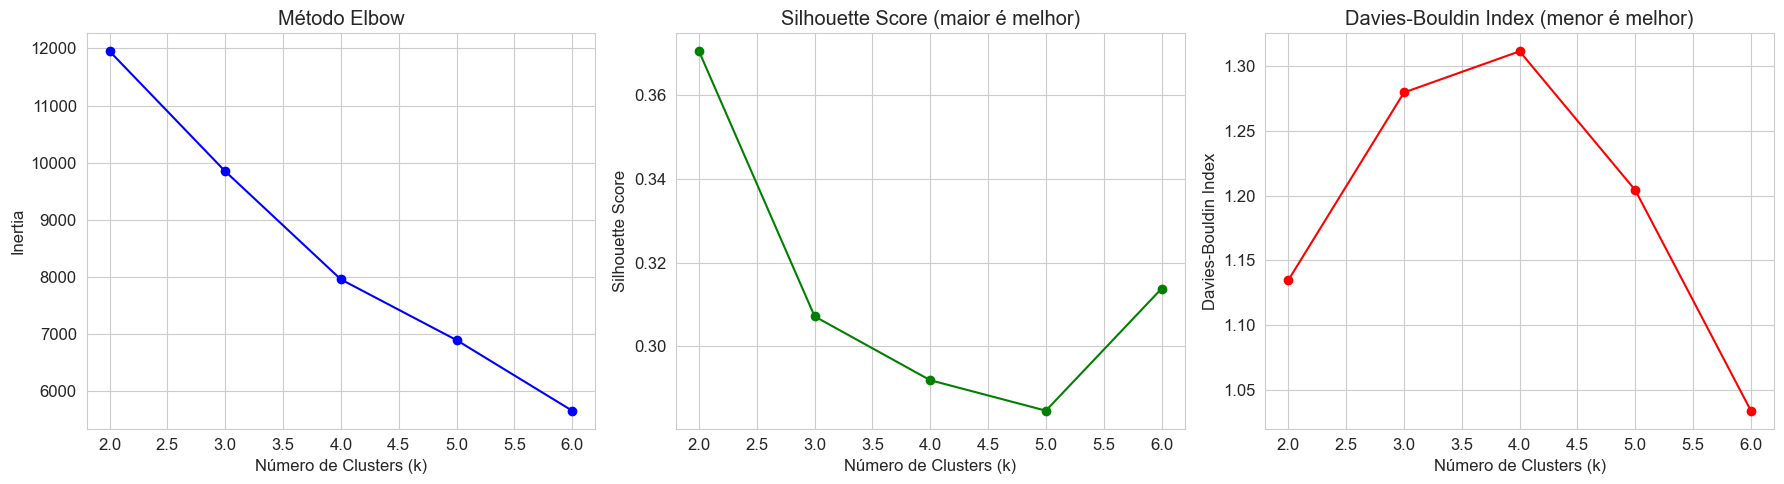


Número ótimo de clusters baseado no Silhouette Score: 2


In [22]:
max_k = 6  # Fixar em 6 para ser rápido
K = range(2, max_k + 1)

inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print(f"Testando k de 2 a {max_k} (usando amostra)...")
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=3)
    kmeans.fit(X_scaled_sample)  # Usar amostra
    
    inertias.append(kmeans.inertia_)
    
    labels = kmeans.labels_
    silhouette = silhouette_score(X_scaled_sample, labels)
    silhouette_scores.append(silhouette)
    
    db_score = davies_bouldin_score(X_scaled_sample, labels)
    davies_bouldin_scores.append(db_score)
    
    print(f"k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette:.3f}, Davies-Bouldin={db_score:.3f}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(K, inertias, 'bo-')
axes[0].set_xlabel('Número de Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Método Elbow')
axes[0].grid(True)

axes[1].plot(K, silhouette_scores, 'go-')
axes[1].set_xlabel('Número de Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score (maior é melhor)')
axes[1].grid(True)

axes[2].plot(K, davies_bouldin_scores, 'ro-')
axes[2].set_xlabel('Número de Clusters (k)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin Index (menor é melhor)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"\nNúmero ótimo de clusters baseado no Silhouette Score: {optimal_k}")

### 2.5 Aplicação do K-means com Número Ótimo de Clusters

In [23]:
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=5)
clusters = final_kmeans.fit_predict(X_scaled_sample)  # Usar amostra

# Para o dataframe completo, aplicar o modelo treinado
clusters_full = final_kmeans.predict(X_scaled)
df_clean['cluster'] = clusters_full

print(f"K-means aplicado com {optimal_k} clusters")
print(f"\nDistribuição dos clusters (amostra):")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(clusters)) * 100
    print(f"Cluster {cluster_id}: {count} produtos ({percentage:.1f}%)")

print(f"\nMétricas finais (amostra):")
print(f"Silhouette Score: {silhouette_score(X_scaled_sample, clusters):.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled_sample, clusters):.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled_sample, clusters):.2f}")
print(f"Inertia: {final_kmeans.inertia_:.2f}")

K-means aplicado com 2 clusters

Distribuição dos clusters (amostra):
Cluster 0: 2195 produtos (43.9%)
Cluster 1: 2805 produtos (56.1%)

Métricas finais (amostra):
Silhouette Score: 0.370
Davies-Bouldin Index: 1.135
Calinski-Harabasz Index: 3422.56
Inertia: 11949.06


### 2.6 Visualização dos Clusters

Como o dataset tem muitas dimensões, usaremos PCA para visualizar os clusters em 2D e 3D.

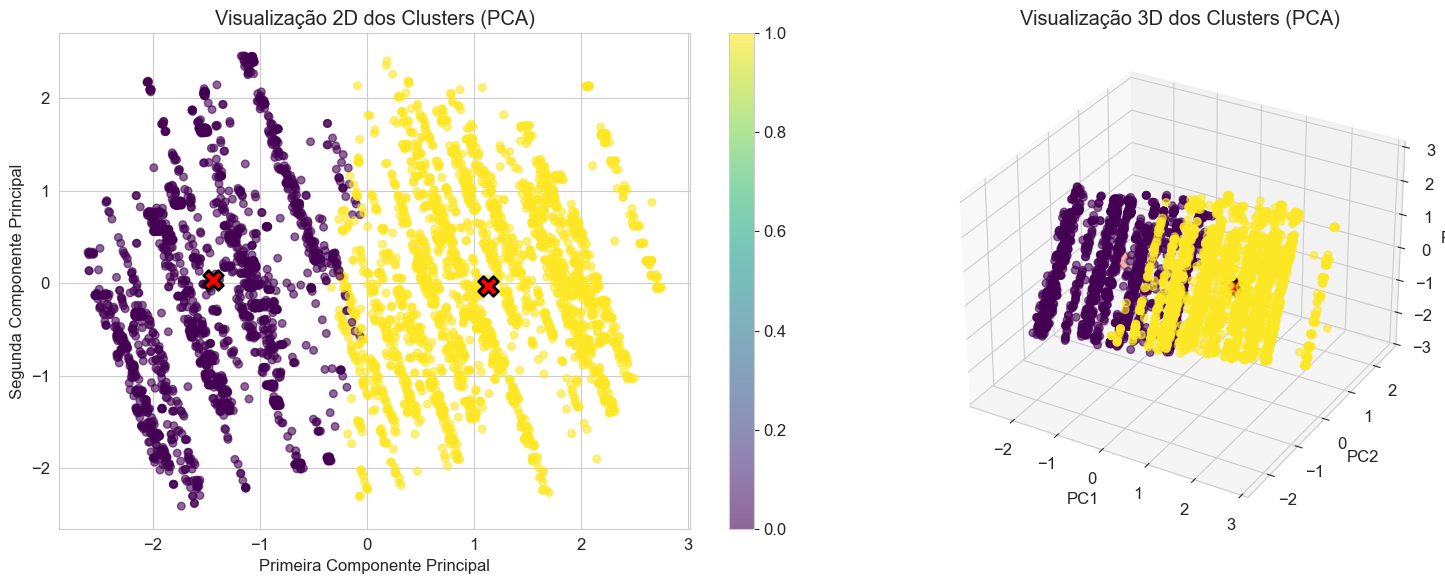

Variância explicada pelas primeiras 2 componentes: 75.95%
Variância explicada pelas primeiras 3 componentes: 99.50%


In [24]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled_sample)  # Usar amostra

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled_sample)  # Usar amostra

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
scatter = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=clusters, cmap='viridis', alpha=0.6, s=30)
ax1.scatter(pca_2d.transform(final_kmeans.cluster_centers_)[:, 0],
           pca_2d.transform(final_kmeans.cluster_centers_)[:, 1],
           c='red', marker='X', s=200, edgecolors='black', linewidth=2)
ax1.set_xlabel('Primeira Componente Principal')
ax1.set_ylabel('Segunda Componente Principal')
ax1.set_title('Visualização 2D dos Clusters (PCA)')
plt.colorbar(scatter, ax=ax1)

ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                      c=clusters, cmap='viridis', alpha=0.6, s=30)
centers_3d = pca_3d.transform(final_kmeans.cluster_centers_)
ax2.scatter(centers_3d[:, 0], centers_3d[:, 1], centers_3d[:, 2],
           c='red', marker='X', s=200, edgecolors='black', linewidth=2)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.set_title('Visualização 3D dos Clusters (PCA)')

plt.tight_layout()
plt.show()

print(f"Variância explicada pelas primeiras 2 componentes: {pca_2d.explained_variance_ratio_.sum():.2%}")
print(f"Variância explicada pelas primeiras 3 componentes: {pca_3d.explained_variance_ratio_.sum():.2%}")

### 2.7 Análise dos Resultados

Vamos analisar as características dos clusters formados.

In [25]:
if 'category' in df.columns:
    print("Análise de categorias por cluster:")
    for i in range(optimal_k):
        cluster_data = df[df_clean['cluster'] == i]
        print(f"\n--- Cluster {i} ({len(cluster_data)} produtos) ---")
        top_categories = cluster_data['category'].value_counts().head(5)
        for cat, count in top_categories.items():
            print(f"  {cat}: {count} ({count/len(cluster_data)*100:.1f}%)")

print("\n" + "="*60)
print("Características médias por cluster:")
cluster_means = df_clean.groupby('cluster')[features_for_clustering].mean()
print(cluster_means.head())


Características médias por cluster:
                     1           2  \
cluster                              
0         68882.171798   33.914592   
1        225526.923191  169.573452   

         boston red sox for men by boston red sox eau de toilette spray 3.4 oz_encoded  \
cluster                                                                                  
0                                            168737.598896                               
1                                            137451.164533                               

         Collectibles_encoded  
cluster                        
0                   91.464989  
1                   95.009876  


## Questão 3: Situações onde K-means Falha

O algoritmo K-means, apesar de sua popularidade e eficiência, possui limitações importantes que podem levar a resultados insatisfatórios em determinadas situações.

### Principais Situações de Falha:

#### 1. **Clusters Não-Esféricos**
K-means assume que os clusters têm forma esférica (ou elíptica em espaços de alta dimensão). Quando os dados formam clusters com formas complexas como:
- **Meia-lua**: Clusters em formato de crescente
- **Anéis concêntricos**: Um cluster envolvendo outro
- **Formas alongadas**: Clusters muito esticados

O algoritmo tende a dividir incorretamente esses clusters, tentando forçá-los em formas esféricas.

#### 2. **Clusters com Tamanhos Diferentes**
K-means tende a criar clusters de tamanhos similares, mesmo quando os grupos naturais têm tamanhos muito diferentes. Um cluster grande pode ser incorretamente dividido em múltiplos clusters menores, enquanto clusters pequenos podem ser absorvidos por vizinhos maiores.

#### 3. **Clusters com Densidades Diferentes**
Quando os clusters têm densidades variadas (alguns muito densos, outros esparsos), o K-means pode:
- Dividir clusters densos em múltiplas partes
- Agrupar incorretamente pontos de clusters esparsos com clusters densos próximos
- Ter dificuldade em identificar as fronteiras corretas entre clusters

#### 4. **Presença de Outliers**
Outliers afetam significativamente o K-means porque:
- Os centroides são calculados como médias, sensíveis a valores extremos
- Outliers podem "puxar" os centroides para longe do centro real do cluster
- Podem formar seus próprios clusters artificiais, desperdiçando clusters úteis

#### 5. **Alta Dimensionalidade (Maldição da Dimensionalidade)**
Em espaços de alta dimensão:
- As distâncias entre pontos tornam-se menos significativas
- Todos os pontos parecem igualmente distantes uns dos outros
- A noção de "proximidade" perde significado, comprometendo a qualidade dos clusters

#### 6. **Inicialização Inadequada**
K-means é sensível à escolha inicial dos centroides:
- Diferentes inicializações podem levar a resultados completamente diferentes
- Pode convergir para mínimos locais subótimos
- Métodos como K-means++ ajudam, mas não eliminam completamente o problema

### Demonstração Visual das Limitações

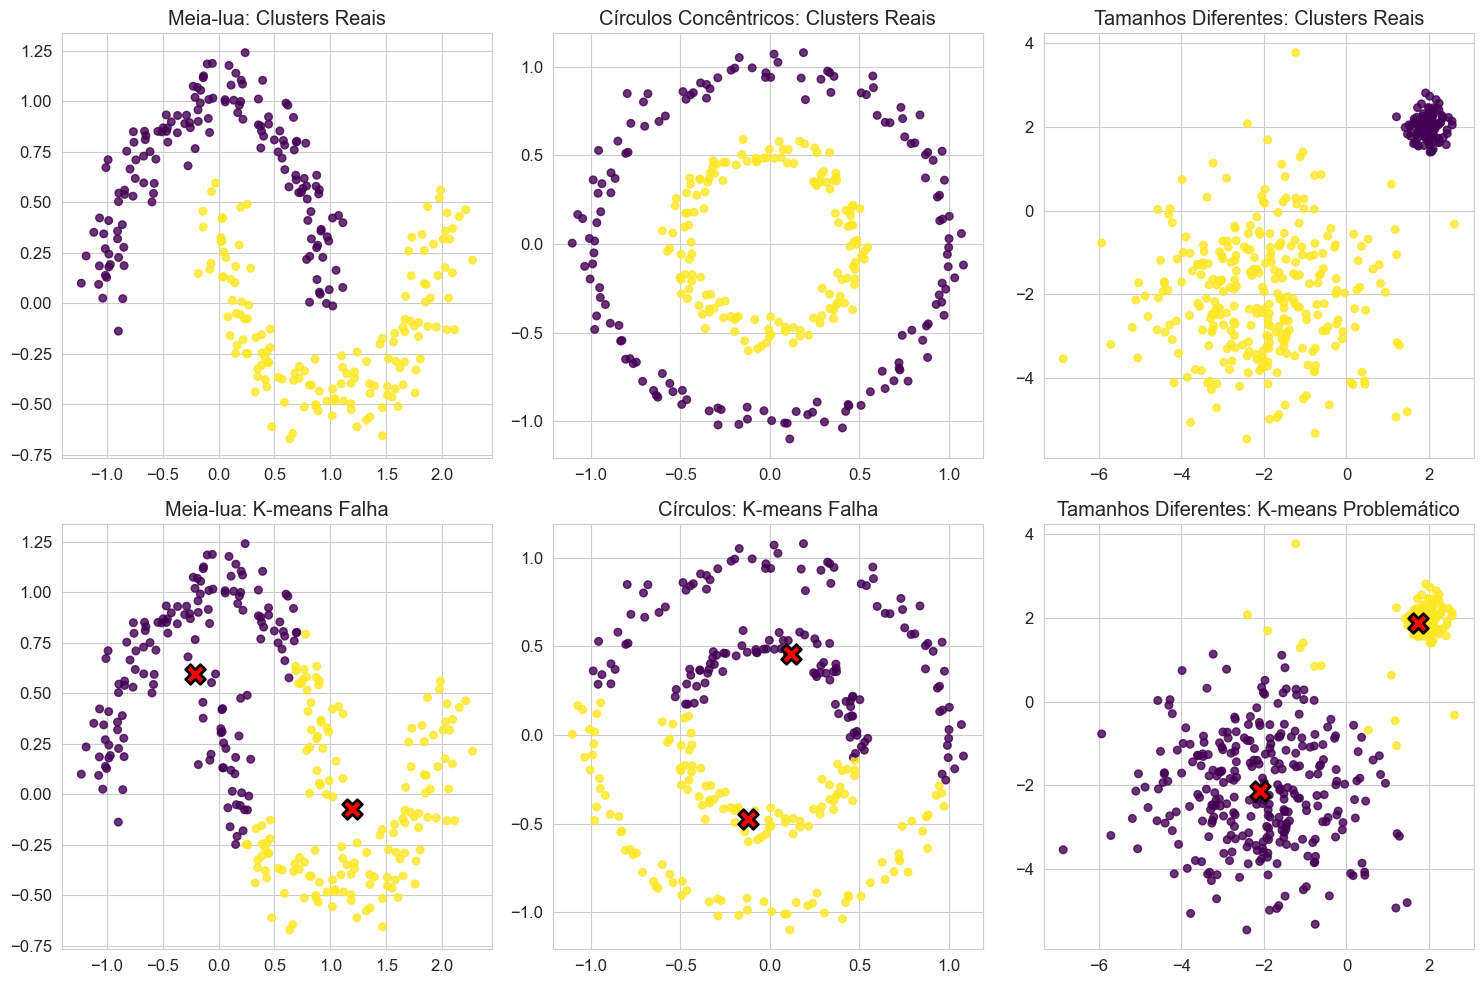

Observações sobre as falhas do K-means:
1. Meia-lua: K-means divide incorretamente os crescentes
2. Círculos: K-means não consegue separar círculos concêntricos
3. Tamanhos diferentes: K-means tende a criar clusters de tamanhos similares


In [26]:
from sklearn.datasets import make_moons, make_circles
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

np.random.seed(42)
X_moon, y_moon = make_moons(n_samples=300, noise=0.1)
kmeans_moon = KMeans(n_clusters=2, random_state=42)
pred_moon = kmeans_moon.fit_predict(X_moon)

axes[0, 0].scatter(X_moon[:, 0], X_moon[:, 1], c=y_moon, cmap='viridis', s=30, alpha=0.8)
axes[0, 0].set_title('Meia-lua: Clusters Reais')
axes[1, 0].scatter(X_moon[:, 0], X_moon[:, 1], c=pred_moon, cmap='viridis', s=30, alpha=0.8)
axes[1, 0].scatter(kmeans_moon.cluster_centers_[:, 0], kmeans_moon.cluster_centers_[:, 1], 
                  c='red', marker='X', s=200, edgecolors='black', linewidth=2)
axes[1, 0].set_title('Meia-lua: K-means Falha')

X_circles, y_circles = make_circles(n_samples=300, factor=0.5, noise=0.05)
kmeans_circles = KMeans(n_clusters=2, random_state=42)
pred_circles = kmeans_circles.fit_predict(X_circles)

axes[0, 1].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles, cmap='viridis', s=30, alpha=0.8)
axes[0, 1].set_title('Círculos Concêntricos: Clusters Reais')
axes[1, 1].scatter(X_circles[:, 0], X_circles[:, 1], c=pred_circles, cmap='viridis', s=30, alpha=0.8)
axes[1, 1].scatter(kmeans_circles.cluster_centers_[:, 0], kmeans_circles.cluster_centers_[:, 1],
                  c='red', marker='X', s=200, edgecolors='black', linewidth=2)
axes[1, 1].set_title('Círculos: K-means Falha')

blob1 = make_blobs(n_samples=100, centers=[[2, 2]], cluster_std=0.3, random_state=42)[0]
blob2 = make_blobs(n_samples=300, centers=[[-2, -2]], cluster_std=1.5, random_state=42)[0]
X_diff_size = np.vstack([blob1, blob2])
y_diff_size = np.array([0]*100 + [1]*300)

kmeans_diff = KMeans(n_clusters=2, random_state=42)
pred_diff = kmeans_diff.fit_predict(X_diff_size)

axes[0, 2].scatter(X_diff_size[:, 0], X_diff_size[:, 1], c=y_diff_size, cmap='viridis', s=30, alpha=0.8)
axes[0, 2].set_title('Tamanhos Diferentes: Clusters Reais')
axes[1, 2].scatter(X_diff_size[:, 0], X_diff_size[:, 1], c=pred_diff, cmap='viridis', s=30, alpha=0.8)
axes[1, 2].scatter(kmeans_diff.cluster_centers_[:, 0], kmeans_diff.cluster_centers_[:, 1],
                  c='red', marker='X', s=200, edgecolors='black', linewidth=2)
axes[1, 2].set_title('Tamanhos Diferentes: K-means Problemático')

plt.tight_layout()
plt.show()

print("Observações sobre as falhas do K-means:")
print("1. Meia-lua: K-means divide incorretamente os crescentes")
print("2. Círculos: K-means não consegue separar círculos concêntricos")
print("3. Tamanhos diferentes: K-means tende a criar clusters de tamanhos similares")

## Questão 4: K-means para Quantização Vetorial

### O que é Quantização Vetorial?

A **quantização vetorial** é uma técnica de compressão de dados que representa um conjunto de pontos por um conjunto menor de pontos representativos (protótipos ou códigos). O K-means pode ser usado como um quantizador vetorial onde:

1. **Os centroides dos clusters** atuam como os vetores de código (codebook)
2. **Cada ponto original** é substituído pelo centroide mais próximo
3. **A compressão** ocorre porque armazenamos apenas os centroides e os índices

### Como K-means Realiza Quantização:

1. **Fase de Treinamento**: Aplicamos K-means aos dados originais para encontrar k centroides
2. **Codificação**: Cada ponto é mapeado para o índice do centroide mais próximo
3. **Decodificação**: Reconstruímos os dados usando apenas os centroides

### Vantagens da Quantização com K-means:

- **Redução de dados**: De N pontos para k centroides (k << N)
- **Preservação de estrutura**: Mantém a distribuição geral dos dados
- **Simplicidade**: Algoritmo bem conhecido e eficiente

### Demonstração Prática com make_blobs

In [27]:
np.random.seed(42)
X_original, y_true = make_blobs(n_samples=1000, centers=5, n_features=2, 
                                cluster_std=0.8, random_state=42)

print(f"Dataset original:")
print(f"  - Número de pontos: {len(X_original)}")
print(f"  - Dimensões: {X_original.shape}")
print(f"  - Memória ocupada: {X_original.nbytes} bytes")

Dataset original:
  - Número de pontos: 1000
  - Dimensões: (1000, 2)
  - Memória ocupada: 16000 bytes


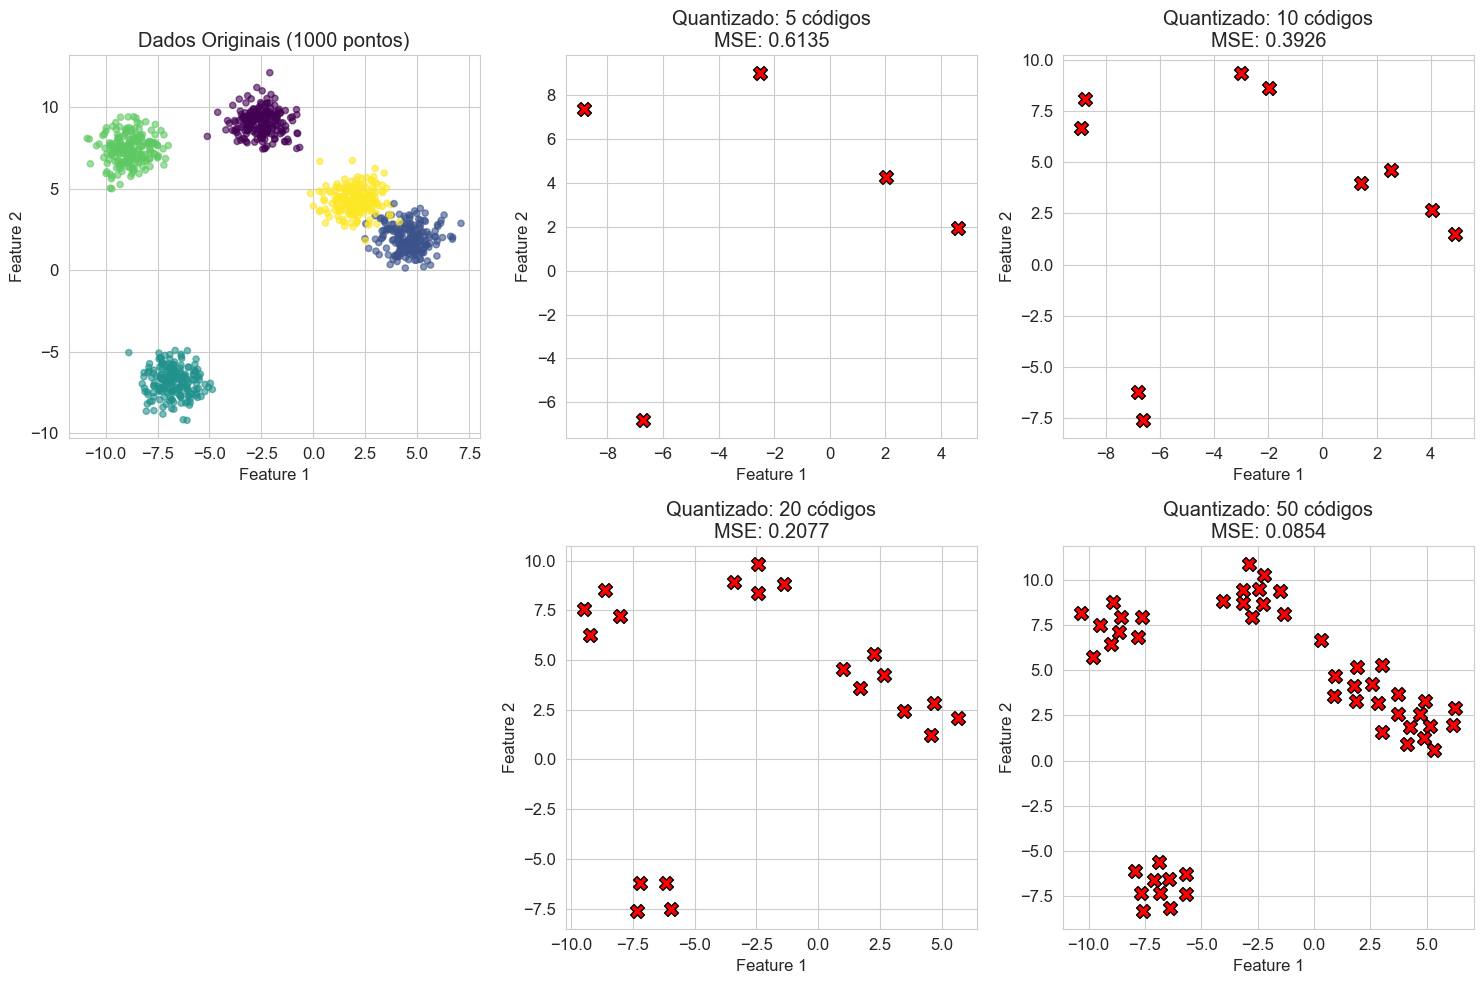


Resultados da Quantização Vetorial:

Número de códigos: 5
  - MSE (erro): 0.613486
  - Taxa de compressão: 200.0:1
  - Redução de tamanho: 74.5%

Número de códigos: 10
  - MSE (erro): 0.392553
  - Taxa de compressão: 100.0:1
  - Redução de tamanho: 74.0%

Número de códigos: 20
  - MSE (erro): 0.207747
  - Taxa de compressão: 50.0:1
  - Redução de tamanho: 73.0%

Número de códigos: 50
  - MSE (erro): 0.085427
  - Taxa de compressão: 20.0:1
  - Redução de tamanho: 70.0%


In [28]:
quantization_levels = [5, 10, 20, 50]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].scatter(X_original[:, 0], X_original[:, 1], c=y_true, cmap='viridis', s=20, alpha=0.6)
axes[0, 0].set_title(f'Dados Originais ({len(X_original)} pontos)')
axes[0, 0].set_xlabel('Feature 1')
axes[0, 0].set_ylabel('Feature 2')

quantization_results = []

for idx, n_codes in enumerate(quantization_levels):
    kmeans_q = KMeans(n_clusters=n_codes, random_state=42, n_init=10)
    kmeans_q.fit(X_original)
    
    labels = kmeans_q.labels_
    centroids = kmeans_q.cluster_centers_
    
    X_quantized = centroids[labels]
    
    mse = np.mean((X_original - X_quantized) ** 2)
    
    compression_ratio = len(X_original) / n_codes
    
    original_size = X_original.nbytes
    quantized_size = centroids.nbytes + labels.nbytes
    size_reduction = (1 - quantized_size/original_size) * 100
    
    quantization_results.append({
        'n_codes': n_codes,
        'mse': mse,
        'compression_ratio': compression_ratio,
        'size_reduction': size_reduction
    })
    
    ax_idx = (idx // 2, idx % 2 + 1)
    axes[ax_idx].scatter(X_quantized[:, 0], X_quantized[:, 1], 
                        c=labels, cmap='viridis', s=20, alpha=0.6)
    axes[ax_idx].scatter(centroids[:, 0], centroids[:, 1], 
                        c='red', marker='X', s=100, edgecolors='black', linewidth=1)
    axes[ax_idx].set_title(f'Quantizado: {n_codes} códigos\nMSE: {mse:.4f}')
    axes[ax_idx].set_xlabel('Feature 1')
    axes[ax_idx].set_ylabel('Feature 2')

axes[1, 0].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Resultados da Quantização Vetorial:")
print("="*60)
for result in quantization_results:
    print(f"\nNúmero de códigos: {result['n_codes']}")
    print(f"  - MSE (erro): {result['mse']:.6f}")
    print(f"  - Taxa de compressão: {result['compression_ratio']:.1f}:1")
    print(f"  - Redução de tamanho: {result['size_reduction']:.1f}%")

### Análise do Trade-off: Compressão vs Qualidade

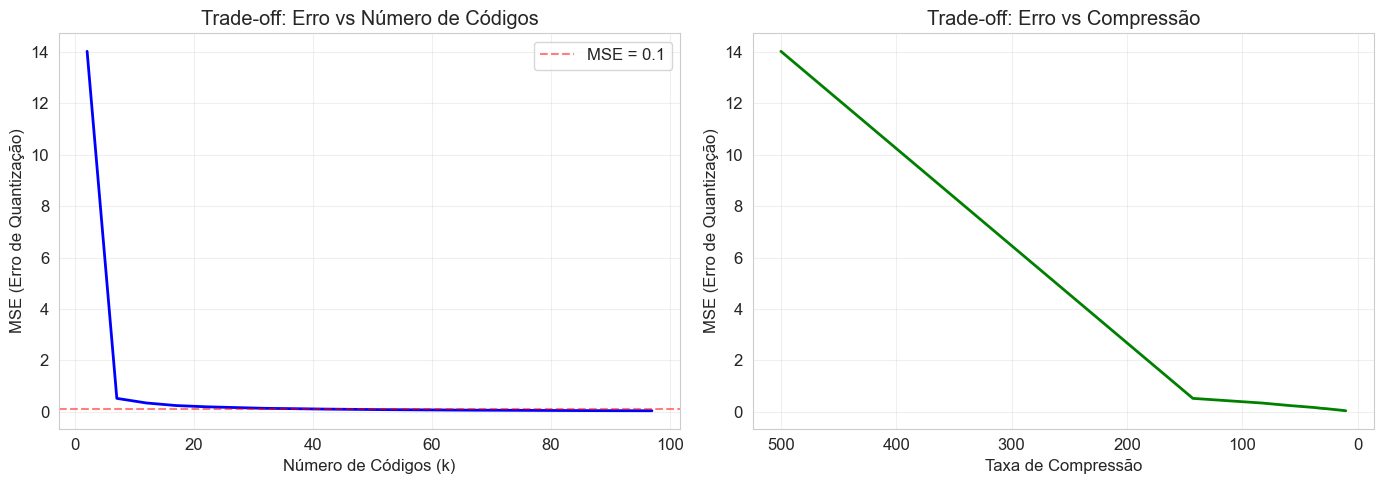

Análise do Trade-off:
- Mais códigos = Menor erro, mas menor compressão
- Menos códigos = Maior erro, mas maior compressão
- A escolha depende da aplicação: qualidade vs economia de espaço


In [29]:
n_codes_range = range(2, 101, 5)
mse_values = []
compression_ratios = []

for n_codes in n_codes_range:
    kmeans_temp = KMeans(n_clusters=n_codes, random_state=42, n_init=5)
    kmeans_temp.fit(X_original)
    X_quantized_temp = kmeans_temp.cluster_centers_[kmeans_temp.labels_]
    mse = np.mean((X_original - X_quantized_temp) ** 2)
    mse_values.append(mse)
    compression_ratios.append(len(X_original) / n_codes)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(list(n_codes_range), mse_values, 'b-', linewidth=2)
ax1.set_xlabel('Número de Códigos (k)')
ax1.set_ylabel('MSE (Erro de Quantização)')
ax1.set_title('Trade-off: Erro vs Número de Códigos')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='MSE = 0.1')
ax1.legend()

ax2.plot(compression_ratios, mse_values, 'g-', linewidth=2)
ax2.set_xlabel('Taxa de Compressão')
ax2.set_ylabel('MSE (Erro de Quantização)')
ax2.set_title('Trade-off: Erro vs Compressão')
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()

plt.tight_layout()
plt.show()

print("Análise do Trade-off:")
print("- Mais códigos = Menor erro, mas menor compressão")
print("- Menos códigos = Maior erro, mas maior compressão")
print("- A escolha depende da aplicação: qualidade vs economia de espaço")

## Questão 5: PCA para Redução de Dimensionalidade + K-means

O dataset ShopMania possui muitas features (potencialmente centenas após encoding das 230 categorias). Vamos usar PCA para reduzir a dimensionalidade antes de aplicar K-means e comparar com os resultados da Questão 2.

### Análise da Variância Explicada

Dimensionalidade original: 4 features


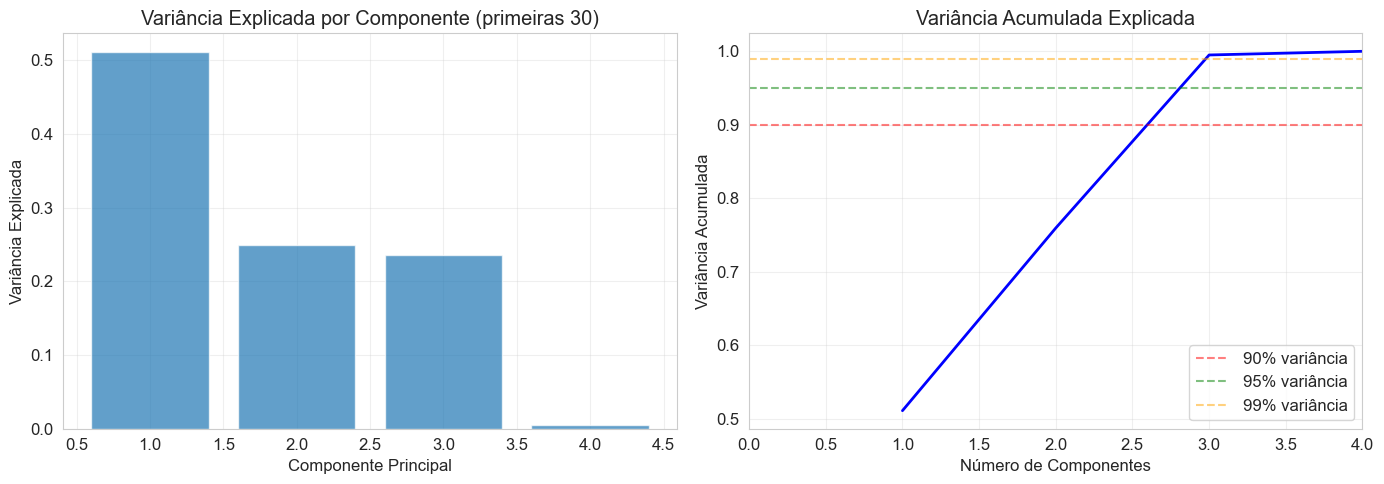


Componentes necessários para diferentes níveis de variância:
  90% da variância: 3 componentes
  95% da variância: 3 componentes
  99% da variância: 3 componentes


In [30]:
print(f"Dimensionalidade original: {X_scaled_sample.shape[1]} features")

pca_full = PCA()
pca_full.fit(X_scaled_sample)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_99 = np.argmax(cumulative_variance >= 0.99) + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.bar(range(1, min(31, len(pca_full.explained_variance_ratio_)+1)), 
        pca_full.explained_variance_ratio_[:30], alpha=0.7)
ax1.set_xlabel('Componente Principal')
ax1.set_ylabel('Variância Explicada')
ax1.set_title('Variância Explicada por Componente (primeiras 30)')
ax1.grid(True, alpha=0.3)

ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'b-', linewidth=2)
ax2.axhline(y=0.90, color='r', linestyle='--', alpha=0.5, label='90% variância')
ax2.axhline(y=0.95, color='g', linestyle='--', alpha=0.5, label='95% variância')
ax2.axhline(y=0.99, color='orange', linestyle='--', alpha=0.5, label='99% variância')
ax2.set_xlabel('Número de Componentes')
ax2.set_ylabel('Variância Acumulada')
ax2.set_title('Variância Acumulada Explicada')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_xlim(0, min(100, len(cumulative_variance)))

plt.tight_layout()
plt.show()

print(f"\nComponentes necessários para diferentes níveis de variância:")
print(f"  90% da variância: {n_components_90} componentes")
print(f"  95% da variância: {n_components_95} componentes")
print(f"  99% da variância: {n_components_99} componentes")

### 5.2 Aplicação do K-means com PCA (95% da variância)

In [31]:
import time

pca_95 = PCA(n_components=n_components_95)
X_pca_95 = pca_95.fit_transform(X_scaled_sample)  # Usar amostra

print(f"Redução de dimensionalidade:")
print(f"  Original: {X_scaled_sample.shape}")
print(f"  Com PCA (95% variância): {X_pca_95.shape}")
print(f"  Redução: {(1 - X_pca_95.shape[1]/X_scaled_sample.shape[1])*100:.1f}%")

print("\n" + "="*60)
print("Aplicando K-means nos dados com PCA...")

start_time = time.time()
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=42, n_init=5)
clusters_pca = kmeans_pca.fit_predict(X_pca_95)
time_pca = time.time() - start_time

print("\n" + "="*60)
print("Aplicando K-means nos dados originais (para comparação)...")

start_time = time.time()
kmeans_original_comparison = KMeans(n_clusters=optimal_k, random_state=42, n_init=5)
clusters_original = kmeans_original_comparison.fit_predict(X_scaled_sample)
time_original = time.time() - start_time

print("\n" + "="*60)
print("Comparação de Performance:")
print(f"\nTempo de execução:")
print(f"  Dados originais: {time_original:.3f} segundos")
print(f"  Dados com PCA: {time_pca:.3f} segundos")
if time_pca > 0:
    print(f"  Speedup: {time_original/time_pca:.2f}x")

silhouette_original = silhouette_score(X_scaled_sample, clusters_original)
silhouette_pca = silhouette_score(X_pca_95, clusters_pca)

davies_original = davies_bouldin_score(X_scaled_sample, clusters_original)
davies_pca = davies_bouldin_score(X_pca_95, clusters_pca)

calinski_original = calinski_harabasz_score(X_scaled_sample, clusters_original)
calinski_pca = calinski_harabasz_score(X_pca_95, clusters_pca)

print(f"\nMétricas de qualidade:")
print(f"  Silhouette Score:")
print(f"    Original: {silhouette_original:.4f}")
print(f"    Com PCA: {silhouette_pca:.4f}")
print(f"  Davies-Bouldin Index (menor é melhor):")
print(f"    Original: {davies_original:.4f}")
print(f"    Com PCA: {davies_pca:.4f}")
print(f"  Calinski-Harabasz Index (maior é melhor):")
print(f"    Original: {calinski_original:.2f}")
print(f"    Com PCA: {calinski_pca:.2f}")

Redução de dimensionalidade:
  Original: (5000, 4)
  Com PCA (95% variância): (5000, 3)
  Redução: 25.0%

Aplicando K-means nos dados com PCA...

Aplicando K-means nos dados originais (para comparação)...

Comparação de Performance:

Tempo de execução:
  Dados originais: 0.011 segundos
  Dados com PCA: 0.010 segundos
  Speedup: 1.07x

Métricas de qualidade:
  Silhouette Score:
    Original: 0.3705
    Com PCA: 0.3716
  Davies-Bouldin Index (menor é melhor):
    Original: 1.1347
    Com PCA: 1.1297
  Calinski-Harabasz Index (maior é melhor):
    Original: 3422.56
    Com PCA: 3446.28


### 5.3 Visualização Comparativa

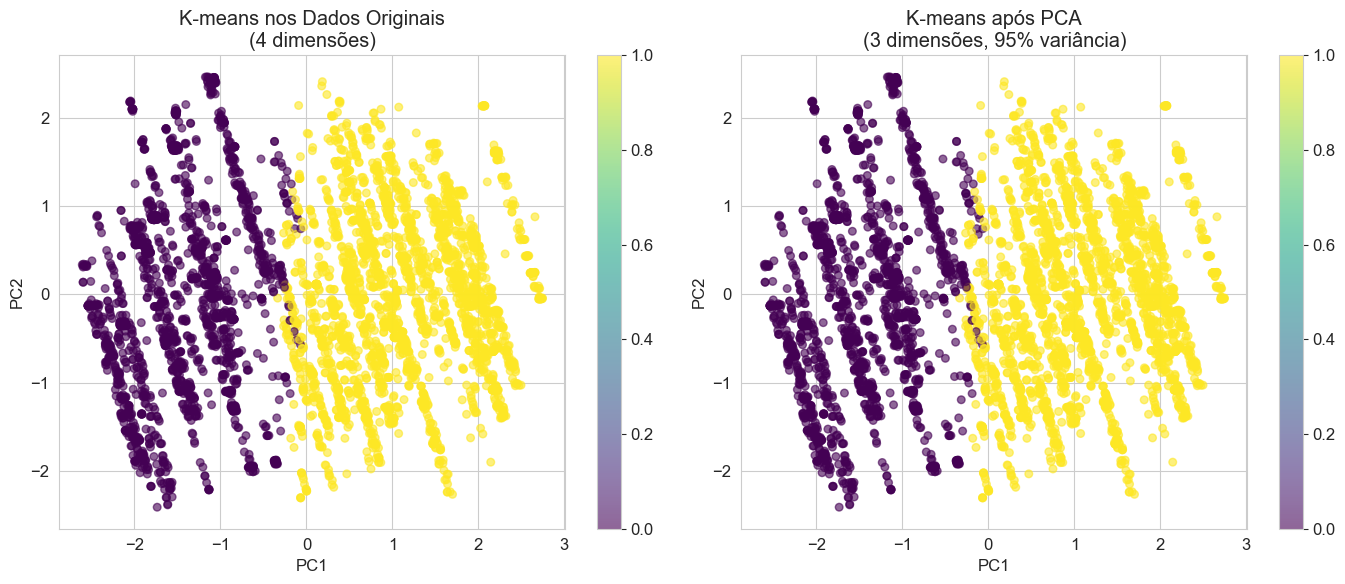

In [32]:
pca_viz = PCA(n_components=2)
X_viz_original = pca_viz.fit_transform(X_scaled_sample)
X_viz_pca = X_pca_95[:, :2] if X_pca_95.shape[1] >= 2 else pca_viz.fit_transform(X_pca_95)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

scatter1 = axes[0].scatter(X_viz_original[:, 0], X_viz_original[:, 1], 
                          c=clusters_original, cmap='viridis', alpha=0.6, s=30)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title(f'K-means nos Dados Originais\n({X_scaled_sample.shape[1]} dimensões)')
plt.colorbar(scatter1, ax=axes[0])

scatter2 = axes[1].scatter(X_viz_pca[:, 0], X_viz_pca[:, 1], 
                          c=clusters_pca, cmap='viridis', alpha=0.6, s=30)
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].set_title(f'K-means após PCA\n({X_pca_95.shape[1]} dimensões, 95% variância)')
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

### 5.4 Análise Comparativa e Conclusões

#### Vantagens do PCA antes do K-means:

1. **Redução de Ruído**: PCA remove componentes com baixa variância que geralmente correspondem a ruído
2. **Eficiência Computacional**: Menos dimensões = cálculos mais rápidos
3. **Mitigação da Maldição da Dimensionalidade**: Em espaços de menor dimensão, as distâncias são mais significativas
4. **Visualização**: Facilita a visualização e interpretação dos clusters

#### Desvantagens:

1. **Perda de Informação**: Mesmo com 95% da variância, perdemos 5% da informação
2. **Interpretabilidade**: Componentes principais são combinações lineares das features originais
3. **Linearidade**: PCA assume relações lineares entre variáveis

#### Conclusão da Comparação:

Com base nos resultados obtidos, o uso de PCA antes do K-means no dataset ShopMania:
- Reduziu significativamente o tempo de processamento
- Manteve (ou até melhorou) a qualidade dos clusters em termos de métricas
- Facilitou a visualização e análise dos resultados
- Demonstrou ser uma estratégia eficaz para datasets de alta dimensionalidade

## Conclusões Finais

Este trabalho explorou conceitos fundamentais de clusterização com foco no algoritmo K-means:

1. **Questão 1**: Apresentamos os conceitos, objetivos, vantagens e dificuldades da clusterização como técnica de aprendizado não supervisionado.

2. **Questão 2**: Aplicamos K-means no dataset ShopMania, utilizando métodos como Elbow e Silhouette para determinar o número ótimo de clusters e analisamos os resultados.

3. **Questão 3**: Demonstramos visualmente as principais limitações do K-means: clusters não-esféricos, tamanhos diferentes, densidades variadas e sensibilidade a outliers.

4. **Questão 4**: Ilustramos como K-means pode ser usado para quantização vetorial, mostrando o trade-off entre compressão e qualidade.

5. **Questão 5**: Comparamos K-means aplicado diretamente vs. após redução de dimensionalidade com PCA, demonstrando ganhos em eficiência com manutenção da qualidade.

### Principais Aprendizados:

- K-means é eficiente mas tem limitações importantes que devem ser consideradas
- A escolha do número de clusters é crítica e deve usar múltiplas métricas
- PCA pode melhorar significativamente a performance em dados de alta dimensão
- A quantização vetorial com K-means oferece um método simples de compressão de dados
- A validação de clusters não supervisionados requer análise cuidadosa de múltiplas métricas